# Serial simulation

In [1]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(name)s,%(levelname)s: %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import numpy as np

In [3]:
from latticemc.definitions import Lattice, LatticeState, OrderParametersHistory, DefiningParameters
from latticemc.latticeTools import initializePartiallyOrdered
from latticemc.randomQuaternion import randomQuaternion
from latticemc.updaters import Updater, OrderParametersCalculator, FluctuationsCalculator, DerivativeWiggleRateAdjustor, RandomWiggleRateAdjustor, CallbackUpdater
from latticemc.failsafe import failsafeSaveSimulation
from latticemc.parallel import SimulationRunner
from latticemc import simulationNumba

In [3]:
lattice = Lattice(9, 9, 9)
initializePartiallyOrdered(lattice, x=randomQuaternion(1))
# initializeRandom(lattice)

modelParams = DefiningParameters(temperature=0.9, lam=0.3, tau=1)
state = LatticeState(parameters=modelParams, lattice=lattice)
orderParametersHistory = {modelParams: OrderParametersHistory()}

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

def plot_progress(state, maxWindow, step):
    op = orderParametersHistory[state.parameters].orderParameters
    plt.close()
    fig,ax = plt.subplots(3);
    fig.tight_layout();
    fig.set_size_inches(10,10);
    start = step if op.size < maxWindow else (op.size-maxWindow)
    size = op.size if op.size < maxWindow else maxWindow
    x = np.linspace(start, start+size, size/step)
    ax[0].plot(x, op['energy'][start::step], label='energy');
    ax[1].plot(x, op['p'][start::step], label='p');
    ax[1].plot(x, op['q0'][start::step], label='q0');
    ax[1].plot(x, op['q2'][start::step], label='q2');
    ax[1].plot(x, op['d322'][start::step], label='d322');
    ax[2].plot(x, op['w'][start::step], label='w');
    ax[0].legend();
    ax[1].legend();
    ax[2].legend();
    display.display(fig)
    display.clear_output(wait=True)

In [21]:
orderParametersCalculator = OrderParametersCalculator(orderParametersHistory, howOften=1, sinceWhen=1)#, printEvery=50)
fluctuationsCalculator = FluctuationsCalculator(orderParametersHistory, window=100, howOften=50, sinceWhen=100)#, printEvery=50)
updaters = [
    orderParametersCalculator,
    fluctuationsCalculator,
    CallbackUpdater(lambda state: plot_progress(state, step=10, maxWindow=10000), howOften=100, sinceWhen=10),
    DerivativeWiggleRateAdjustor(howMany=100, howOften=10, sinceWhen=101),
    RandomWiggleRateAdjustor(scale=0.001, howOften=10, sinceWhen=1),
    RandomWiggleRateAdjustor(scale=1.0, resetValue=1.0, howOften=1000, sinceWhen=1000),
]

KeyboardInterrupt: 

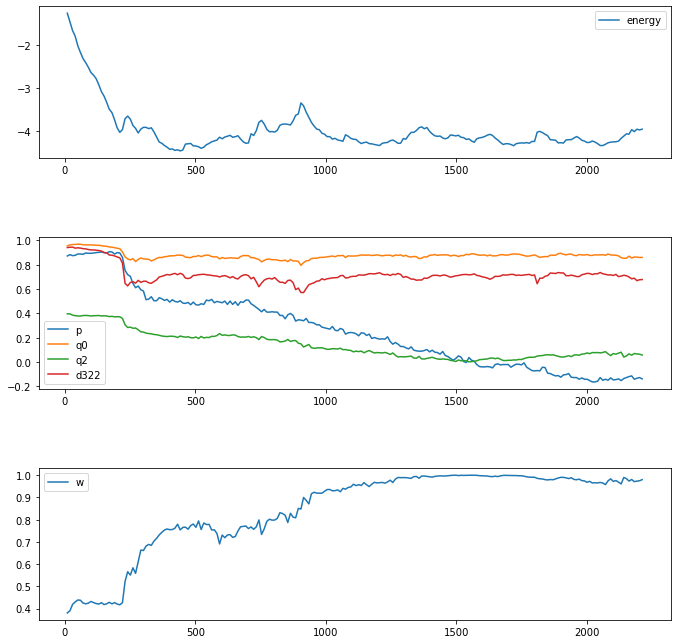

In [22]:
for it in range(100000):
    simulationNumba.doLatticeStateUpdate(state)

    for u in updaters:
        u.perform(state)

# Parallel simulations

In [10]:
from decimal import Decimal

temperatures = np.arange(0.4, 1.0, 0.02)
temperatures = np.append(temperatures, np.arange(1.0, 1.7, 0.04))
temperatures = np.append(temperatures, np.arange(1.7, 2.8, 0.05))
states = [LatticeState(parameters=DefiningParameters(temperature=round(Decimal(t), 2), lam=0.3, tau=1),
                       lattice=Lattice(16, 16, 16))
          for t in temperatures]
for state in states:
    initializePartiallyOrdered(state.lattice, x=randomQuaternion(1.0))

orderParametersHistory = {state.parameters: OrderParametersHistory() for state in states}

In [11]:
perStateUpdaters = [
    #DerivativeWiggleRateAdjustor(howMany=100, howOften=10, sinceWhen=100),
    RandomWiggleRateAdjustor(scale=0.001, howOften=10, sinceWhen=10),
    RandomWiggleRateAdjustor(scale=1.0, resetValue=1.0, howOften=1000, sinceWhen=1000)
]

runner = SimulationRunner(states,
                          orderParametersHistory,
                          cycles=100000,
                          reportOrderParametersEvery=1000,
                          reportStateEvery=10000,
                          perStateUpdaters=perStateUpdaters,
                          parallelTemperingInterval=100)
runner.start()

latticemc.parallel,WARNING: SimulationProcess[13, DefiningParameters(temperature=Decimal('0.74'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[8, DefiningParameters(temperature=Decimal('0.58'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[6, DefiningParameters(temperature=Decimal('0.52'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[13, DefiningParameters(temperature=Decimal('0.76'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[3, DefiningParameters(temperature=Decimal('0.44'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[2, DefiningParameters(temperature=Decimal('0.48'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[10, DefiningParameters(tempe

latticemc.parallel,WARNING: SimulationProcess[15, DefiningParameters(temperature=Decimal('0.72'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[8, DefiningParameters(temperature=Decimal('0.64'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[16, DefiningParameters(temperature=Decimal('0.70'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[0, DefiningParameters(temperature=Decimal('0.52'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[4, DefiningParameters(temperature=Decimal('0.40'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[7, DefiningParameters(temperature=Decimal('0.64'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[13, DefiningParameters(tempe

latticemc.parallel,WARNING: SimulationProcess[9, DefiningParameters(temperature=Decimal('0.86'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[11, DefiningParameters(temperature=Decimal('0.48'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[12, DefiningParameters(temperature=Decimal('0.52'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[3, DefiningParameters(temperature=Decimal('0.40'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[12, DefiningParameters(temperature=Decimal('0.52'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[9, DefiningParameters(temperature=Decimal('0.86'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[3, DefiningParameters(tempe

latticemc.parallel,WARNING: SimulationProcess[9, DefiningParameters(temperature=Decimal('0.72'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[11, DefiningParameters(temperature=Decimal('0.56'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[1, DefiningParameters(temperature=Decimal('0.48'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[11, DefiningParameters(temperature=Decimal('0.56'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[1, DefiningParameters(temperature=Decimal('0.50'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[3, DefiningParameters(temperature=Decimal('0.40'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[8, DefiningParameters(temper

latticemc.parallel,WARNING: SimulationProcess[12, DefiningParameters(temperature=Decimal('0.50'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[6, DefiningParameters(temperature=Decimal('1.20'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[8, DefiningParameters(temperature=Decimal('0.56'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[4, DefiningParameters(temperature=Decimal('0.40'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[14, DefiningParameters(temperature=Decimal('0.48'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[4, DefiningParameters(temperature=Decimal('0.40'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[14, DefiningParameters(tempe

latticemc.parallel,WARNING: SimulationProcess[8, DefiningParameters(temperature=Decimal('0.54'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[5, DefiningParameters(temperature=Decimal('0.86'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[4, DefiningParameters(temperature=Decimal('0.40'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[0, DefiningParameters(temperature=Decimal('0.86'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[15, DefiningParameters(temperature=Decimal('0.72'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[13, DefiningParameters(temperature=Decimal('0.60'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[14, DefiningParameters(tempe

In [12]:
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

class Plotter:
    def __init__(self, temperatures, orderParametersHistory, window=1000):
        self.orderParametersHistory = orderParametersHistory
        self.x = [float(t) for t in temperatures]
        self.energy = [0 for _ in self.x]
        self.specificHeat = [0 for _ in self.x]
        self.q0 = [0 for _ in self.x]
        self.q2 = [0 for _ in self.x]
        self.par = [0 for _ in self.x]
        self.d322 = [0 for _ in self.x]
        self.w = [0 for _ in self.x]
        self.window = window

        self.opfig, self.opax = plt.subplots(2);
        self.opfig.set_size_inches(10,12)
        self.opax[0].plot(self.x,self.energy, label='energy', marker='o', linestyle=None);
        self.opax[0].plot(self.x,self.specificHeat, label='specificHeat', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.q0, label='q0', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.q2, label='q2', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.par, label='p', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.d322, label='d322', marker='o', linestyle=None);
        self.opax[0].legend();
        self.opax[1].legend();
        
        self.ani = FuncAnimation(self.opfig, self.plotUpdate, interval=1000, repeat=True)
        self.opfig

    def plotUpdate(self, _):
        for p, oph in self.orderParametersHistory.items():
            op = oph.orderParameters
            fl = oph.fluctuations
            t_index = np.nonzero(np.isclose(self.x, float(p.temperature)))[0][0]
            size = op.size if op.size < self.window else self.window
            fl_size = fl.size if fl.size < self.window else self.window
            
            self.energy[t_index] = op['energy'][-size:].mean() if op.size else 0
            self.specificHeat[t_index] = fl['energy'][-fl_size:].mean() if fl.size else 0
            self.q0[t_index] = op['q0'][-size:].mean() if op.size else 0
            self.q2[t_index] = op['q2'][-size:].mean() if op.size else 0
            self.par[t_index] = np.abs(op['p'][-size:]).mean() if op.size else 0
            self.d322[t_index] = op['d322'][-size:].mean() if op.size else 0

        self.opax[0].lines[0].set_ydata(self.energy)
        self.opax[0].lines[1].set_ydata(self.specificHeat)
        self.opax[1].lines[0].set_ydata(self.q0)
        self.opax[1].lines[1].set_ydata(self.q2)
        self.opax[1].lines[2].set_ydata(self.par)
        self.opax[1].lines[3].set_ydata(self.d322)

        self.opax[0].relim()
        self.opax[0].autoscale_view()
        self.opax[1].relim()
        self.opax[1].autoscale_view()

plotter = Plotter(temperatures, orderParametersHistory, window=0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.75'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.75'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.75'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.75'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.75'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.75'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(t

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.25'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.15'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.75'), tau=1, lam=0.3)]: No parallel tempering data to exchange
latticemc.parallel,WARNING: SimulationProcess[69, DefiningParameters(temperature=Decimal('2.35'), tau=1, lam=0.3)]: No parallel tempering data to exchange


In [14]:
fig, ax = plt.subplots();
ax.plot(orderParametersHistory[states[25].parameters].orderParameters['energy'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
sph = []

[0.4,
 0.42000000000000004,
 0.44000000000000006,
 0.4600000000000001,
 0.4800000000000001,
 0.5000000000000001,
 0.5200000000000001,
 0.5400000000000001,
 0.5600000000000002,
 0.5800000000000002,
 0.6000000000000002,
 0.6200000000000002,
 0.6400000000000002,
 0.6600000000000003,
 0.6800000000000003,
 0.7000000000000003,
 0.7200000000000003,
 0.7400000000000003,
 0.7600000000000003,
 0.7800000000000004,
 0.8000000000000004,
 0.8200000000000004,
 0.8400000000000004,
 0.8600000000000004,
 0.8800000000000004,
 0.9000000000000005,
 0.9200000000000005,
 0.9400000000000005,
 0.9600000000000005,
 0.9800000000000005,
 1.0,
 1.04,
 1.08,
 1.12,
 1.1600000000000001,
 1.2000000000000002,
 1.2400000000000002,
 1.2800000000000002,
 1.3200000000000003,
 1.3600000000000003,
 1.4000000000000004,
 1.4400000000000004,
 1.4800000000000004,
 1.5200000000000005,
 1.5600000000000005,
 1.6000000000000005,
 1.6400000000000006,
 1.6800000000000006,
 1.7,
 1.75,
 1.8,
 1.85,
 1.9000000000000001,
 1.950000000000

# OpenCL

In [1]:
%load_ext pyopencl.ipython_ext

In [1]:
import pyopencl as cl
import pyopencl.array
import numpy as np

In [2]:
ctx = cl.create_some_context()

In [3]:
queue = cl.CommandQueue(ctx)

In [7]:
from latticemc.definitions import particle, particle_cdecl

particle = cl.tools.get_or_register_dtype("particle", particle)

In [13]:
mf = cl.mem_flags
nlat = np.zeros_like(lattice.particles)
lattice_g = cl.array.to_device(queue, lattice.particles)
nlat_g = cl.array.to_device(queue, nlat)

prg = cl.Program(ctx, particle_cdecl+"""
__kernel void list(__global const particle *g_lattice, __global particle *g_nlat)
{
  int i = get_global_id(0);
  int j = get_global_id(1);
  int k = get_global_id(2);
  g_nlat[i*18+j*9+k].index = g_lattice[i*18+j*9+k].index;
  g_nlat[i*18+j*9+k].x = g_lattice[i*18+j*9+k].x;
  for(int n=0; n<10; ++n)
      g_nlat[i*18+j*9+k].t32[n] = g_lattice[i*18+j*9+k].t32[n];
  for(int n=0; n<6; ++n) {
      g_nlat[i*18+j*9+k].t22[n] = g_lattice[i*18+j*9+k].t22[n];
      g_nlat[i*18+j*9+k].t20[n] = g_lattice[i*18+j*9+k].t20[n];
  }
  g_nlat[i*18+j*9+k].p = g_lattice[i*18+j*9+k].p;
  g_nlat[i*18+j*9+k].energy = g_lattice[i*18+j*9+k].energy;
}
""").build()

prg.list(queue, nlat_g.shape, None, lattice_g.data, nlat_g.data)
nlat = nlat_g.get()